In [1]:
# Standard library
import math
import pickle
from collections import defaultdict
from pathlib import Path

# Third-party
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from simpy import Environment

# Simulador - Core
from simulador import analysis
from simulador.main import Simulator
from simulador import Scenario, ScenarioGenerator, Metrics
from simulador.config.settings import NUMERO_DE_REQUISICOES, NUMERO_DE_SLOTS
from simulador import routing

# Simulador - Analysis
from simulador import analysis, visualization

# Simulador - Visualization
from simulador.visualization import (
    availability_plots,
    traffic_plots,
)

# Jupyter configuration
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load topology
TOPOLOGY = nx.read_weighted_edgelist("topology/usa", nodetype=int)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


In [2]:
with open("output/cenario_disaster_aware.pkl", "rb") as file:
    cenario_base = pickle.load(file)

In [3]:
from fractions import Fraction

# ============================================================
# USER-FRIENDLY PARAMETERS - Specify what you conceptually want
# ============================================================
desired_min = 0     # Will become 0.0 (i.e., 0/10)
desired_max = 20     # Will become 0.5 (i.e., 5/10)
desired_step = 10  # Will create steps of 0.25 (i.e., 2.5/10)

# ============================================================
# AUTOMATIC CONVERSION - Makes it work with range()
# ============================================================
# Find the smallest multiplier to convert step into an integer
# For step=2.5: multiplier=2 (2.5*2=5)
# For step=1.5: multiplier=2 (1.5*2=3)  
# For step=0.33: multiplier=100 (0.33*100=33)
frac = Fraction(str(desired_step)).limit_denominator(1000)
multiplier = frac.denominator

# Convert all parameters to integers for range()
min_range = int(desired_min * multiplier)
max_range = int(desired_max * multiplier)
step = int(desired_step * multiplier)

# Calculate divisor to get final values in the x/10 format you want
divisor = multiplier * 10

# Generate weight combinations - always ends up as x/10
list_of_weights = [(i/divisor, j/divisor, k/divisor) 
                   for i in range(min_range, max_range + 1, step)
                   for j in range(min_range, max_range + 1, step)
                   for k in range(min_range, max_range + 1, step)]

print(f"✓ Generated {len(list_of_weights)} weight combinations")
print(f"✓ Range: {min(w[0] for w in list_of_weights):.2f} to {max(w[0] for w in list_of_weights):.2f}")
print(f"✓ Unique values for each weight: {sorted(set(w[0] for w in list_of_weights))}")
print(f"\nFirst 5 combinations: {list_of_weights[:5]}")

✓ Generated 27 weight combinations
✓ Range: 0.00 to 2.00
✓ Unique values for each weight: [0.0, 1.0, 2.0]

First 5 combinations: [(0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (0.0, 0.0, 2.0), (0.0, 1.0, 0.0), (0.0, 1.0, 1.0)]


In [4]:
list_of_weights

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0),
 (0.0, 0.0, 2.0),
 (0.0, 1.0, 0.0),
 (0.0, 1.0, 1.0),
 (0.0, 1.0, 2.0),
 (0.0, 2.0, 0.0),
 (0.0, 2.0, 1.0),
 (0.0, 2.0, 2.0),
 (1.0, 0.0, 0.0),
 (1.0, 0.0, 1.0),
 (1.0, 0.0, 2.0),
 (1.0, 1.0, 0.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 2.0),
 (1.0, 2.0, 0.0),
 (1.0, 2.0, 1.0),
 (1.0, 2.0, 2.0),
 (2.0, 0.0, 0.0),
 (2.0, 0.0, 1.0),
 (2.0, 0.0, 2.0),
 (2.0, 1.0, 0.0),
 (2.0, 1.0, 1.0),
 (2.0, 1.0, 2.0),
 (2.0, 2.0, 0.0),
 (2.0, 2.0, 1.0),
 (2.0, 2.0, 2.0)]

In [5]:
# Generate scenarios with different weights
# Note: Generation is fast (~1-2 min), caching would be slower due to large file size
print("🔧 Generating scenarios with different weights...")
print("   (This is fast - just deep copying and recomputing paths)")

scenarios = ScenarioGenerator.gerar_cenarios_com_diferentes_pesos(cenario_base, list_of_weights)

print(f"✓ Generated {len(scenarios)} scenarios")
print(f"✓ Ready to run experiments")

# Optional: If you still want to cache (NOT RECOMMENDED - very slow and large file)
# scenarios_cache_path = Path("output/best_weight_experiment/generated_scenarios.pkl")
# with open(scenarios_cache_path, "wb") as f:
#     pickle.dump(scenarios, f)


🔧 Generating scenarios with different weights...
   (This is fast - just deep copying and recomputing paths)
Creating scenario variant 1/27 with α=0.00, β=0.00, γ=0.00
Creating scenario variant 2/27 with α=0.00, β=0.00, γ=1.00
Creating scenario variant 3/27 with α=0.00, β=0.00, γ=2.00
Creating scenario variant 4/27 with α=0.00, β=1.00, γ=0.00
Creating scenario variant 5/27 with α=0.00, β=1.00, γ=1.00
Creating scenario variant 6/27 with α=0.00, β=1.00, γ=2.00
Creating scenario variant 7/27 with α=0.00, β=2.00, γ=0.00
Creating scenario variant 8/27 with α=0.00, β=2.00, γ=1.00
Creating scenario variant 9/27 with α=0.00, β=2.00, γ=2.00
Creating scenario variant 10/27 with α=1.00, β=0.00, γ=0.00
Creating scenario variant 11/27 with α=1.00, β=0.00, γ=1.00
Creating scenario variant 12/27 with α=1.00, β=0.00, γ=2.00
Creating scenario variant 13/27 with α=1.00, β=1.00, γ=0.00
Creating scenario variant 14/27 with α=1.00, β=1.00, γ=1.00
Creating scenario variant 15/27 with α=1.00, β=1.00, γ=2.00


## Run Experiments in Parallel

Now we'll run all scenarios in parallel using **multiprocessing** (not threading) for true parallel execution:

### Why Multiprocessing?
- **Python GIL limitation**: Threading doesn't provide true parallelism for CPU-bound tasks
- **SimPy simulations are CPU-intensive**: Event processing, routing calculations
- **ProcessPoolExecutor**: Spawns separate Python processes, bypassing the GIL
- **Expected speedup**: ~8x with 8 CPU cores (vs. sequential execution)

### ⚠️ Why Worker Function is in a Separate File

The worker function is imported from `experiment_worker.py` instead of being defined in this notebook because:
- **macOS uses `spawn` multiprocessing**: Each worker starts with a fresh Python interpreter
- **Jupyter notebooks can't be imported**: Functions defined in cells exist only in the `__main__` namespace
- **Pickling fails**: When `ProcessPoolExecutor` tries to send the function to workers, it can't find it
- **Solution**: External `.py` module can be imported by all worker processes ✓

### Expected Time
- **Per scenario**: ~2 minutes
- **125 scenarios total**: 
  - Sequential: ~250 minutes (4+ hours)
  - Parallel (8 cores): ~32 minutes ⚡
  
Results will be saved to organized directories for each weight configuration.


In [6]:
import os
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime

# Create base output directory
BASE_OUTPUT_DIR = Path("output/best_weight_experiment")
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Output directory created: {BASE_OUTPUT_DIR}")
print(f"✓ Total scenarios to run: {len(scenarios)}")
print(f"✓ Available CPU cores: {os.cpu_count()}")


✓ Output directory created: output/best_weight_experiment
✓ Total scenarios to run: 27
✓ Available CPU cores: 10


In [7]:
# Import worker function from separate module (required for multiprocessing)
from experiment_worker import run_scenario_experiment

print("✓ Worker function imported from experiment_worker.py")


✓ Worker function imported from experiment_worker.py


In [8]:
# Run all scenarios in parallel using multiprocessing
print(f"Starting parallel execution of {len(scenarios)} scenarios...")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 80)

# Track results
results = []
start_time = datetime.now()

# Use ProcessPoolExecutor for TRUE parallel execution (bypasses Python GIL)
# Adjust max_workers based on your CPU cores
max_workers = min(os.cpu_count() or 4, 8)  # Use up to 8 parallel workers
print(f"Using {max_workers} parallel processes")
print("-" * 80)

# Prepare arguments for each scenario
scenario_args = [
    (scenario, idx, len(scenarios), str(BASE_OUTPUT_DIR))
    for idx, scenario in enumerate(scenarios)
]

# Run scenarios in parallel
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all scenarios
    futures = [executor.submit(run_scenario_experiment, args) for args in scenario_args]
    
    # Process completed scenarios as they finish
    for future in as_completed(futures):
        result = future.result()
        results.append(result)

# Calculate statistics
end_time = datetime.now()
duration = end_time - start_time
successful = sum(1 for r in results if r[0])
failed = len(results) - successful

print("-" * 80)
print(f"\n{'='*80}")
print(f"EXPERIMENT COMPLETED")
print(f"{'='*80}")
print(f"Total scenarios: {len(scenarios)}")
print(f"Successful: {successful}")
print(f"Failed: {failed}")
print(f"Duration: {duration}")
print(f"Average time per scenario: {duration / len(scenarios)}")
print(f"Speedup vs sequential: {len(scenarios) * 2 / (duration.total_seconds() / 60):.2f}x")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nResults saved to: {BASE_OUTPUT_DIR}")
print(f"{'='*80}")


Starting parallel execution of 27 scenarios...
Start time: 2025-11-16 16:20:54
--------------------------------------------------------------------------------
Using 8 parallel processes
--------------------------------------------------------------------------------
[1/27] Starting: α=0.0, β=0.0, γ=0.0
[2/27] Starting: α=0.0, β=0.0, γ=1.0
[3/27] Starting: α=0.0, β=0.0, γ=2.0
[4/27] Starting: α=0.0, β=1.0, γ=0.0
[5/27] Starting: α=0.0, β=1.0, γ=1.0
[6/27] Starting: α=0.0, β=1.0, γ=2.0
[7/27] Starting: α=0.0, β=2.0, γ=0.0
[8/27] Starting: α=0.0, β=2.0, γ=1.0
[1/27] ✓ Completed: α=0.0, β=0.0, γ=0.0
[2/27] ✓ Completed: α=0.0, β=0.0, γ=1.0
[9/27] Starting: α=0.0, β=2.0, γ=2.0
[3/27] ✓ Completed: α=0.0, β=0.0, γ=2.0
[4/27] ✓ Completed: α=0.0, β=1.0, γ=0.0
[10/27] Starting: α=1.0, β=0.0, γ=0.0
[5/27] ✓ Completed: α=0.0, β=1.0, γ=1.0
[6/27] ✓ Completed: α=0.0, β=1.0, γ=2.0
[11/27] Starting: α=1.0, β=0.0, γ=1.0
[7/27] ✓ Completed: α=0.0, β=2.0, γ=0.0
[12/27] Starting: α=1.0, β=0.0, γ=2.0
[8/27

In [9]:
# Create a summary CSV of all experiments
summary_data = []

for success, alpha, beta, gamma, output_dir in results:
    if success:
        # Read the dataframe to get summary statistics
        df_path = Path(output_dir) / f"dataframe_{alpha:.1f}_{beta:.1f}_{gamma:.1f}.csv"
        try:
            df = pd.read_csv(df_path, low_memory=False)
            
            # Calculate summary metrics (overall)
            total_requests = len(df)
            blocked_requests = df['bloqueada'].sum()
            blocking_rate = blocked_requests / total_requests if total_requests > 0 else 0
            availability = 1 - blocking_rate
            
            # Calculate migration-specific metrics
            migration_df = df[df['requisicao_de_migracao'] == True]
            migration_total = len(migration_df)
            migration_blocked = migration_df['bloqueada'].sum() if migration_total > 0 else 0
            migration_blocking_rate = migration_blocked / migration_total if migration_total > 0 else 0
            migration_availability = 1 - migration_blocking_rate if migration_total > 0 else 0
            
            summary_data.append({
                'alpha': alpha,
                'beta': beta,
                'gamma': gamma,
                'total_requests': total_requests,
                'blocked_requests': int(blocked_requests),
                'blocking_rate': blocking_rate,
                'availability': availability,
                'migration_total': migration_total,
                'migration_blocked': int(migration_blocked),
                'migration_blocking_rate': migration_blocking_rate,
                'migration_availability': migration_availability,
                'output_dir': output_dir,
                'success': True
            })
        except Exception as e:
            print(f"Warning: Could not read results for α={alpha:.1f}, β={beta:.1f}, γ={gamma:.1f}: {e}")
            summary_data.append({
                'alpha': alpha,
                'beta': beta,
                'gamma': gamma,
                'total_requests': 0,
                'blocked_requests': 0,
                'blocking_rate': 0,
                'availability': 0,
                'migration_total': 0,
                'migration_blocked': 0,
                'migration_blocking_rate': 0,
                'migration_availability': 0,
                'output_dir': output_dir,
                'success': False
            })
    else:
        summary_data.append({
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'total_requests': 0,
            'blocked_requests': 0,
            'blocking_rate': 0,
            'availability': 0,
            'migration_total': 0,
            'migration_blocked': 0,
            'migration_blocking_rate': 0,
            'migration_availability': 0,
            'output_dir': output_dir,
            'success': False
        })

# Create summary dataframe
summary_df = pd.DataFrame(summary_data)

# Save summary
summary_path = BASE_OUTPUT_DIR / "experiment_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"✓ Summary saved to: {summary_path}")
print(f"\nTop 10 configurations by availability:")
print(summary_df.nlargest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])
print(f"\nTop 10 configurations by migration availability:")
print(summary_df.nlargest(10, 'migration_availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])


✓ Summary saved to: output/best_weight_experiment/experiment_summary.csv

Top 10 configurations by availability:
    alpha  beta  gamma  availability  migration_availability
2     0.0   0.0    2.0      0.634483                0.409110
1     0.0   0.0    1.0      0.634417                0.409110
0     0.0   0.0    0.0      0.634212                0.411532
9     1.0   0.0    0.0      0.634046                0.410725
10    1.0   0.0    1.0      0.634046                0.410725
7     0.0   2.0    1.0      0.634042                0.411915
8     0.0   2.0    2.0      0.633975                0.411915
4     0.0   1.0    1.0      0.633947                0.411915
6     0.0   2.0    0.0      0.633913                0.411915
19    2.0   0.0    1.0      0.633828                0.409748

Top 10 configurations by migration availability:
    alpha  beta  gamma  availability  migration_availability
14    1.0   1.0    2.0      0.633719                0.412510
11    1.0   0.0    2.0      0.633733        

In [10]:
print(f"\nTop 10 worstconfigurations by availability:")

print(summary_df.nsmallest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])

print(f"\nTop 10 worstconfigurations by migration availability:")

print(summary_df.nsmallest(10, 'availability')[['alpha', 'beta', 'gamma', 'availability', 'migration_availability']])



Top 10 worstconfigurations by availability:
    alpha  beta  gamma  availability  migration_availability
18    2.0   0.0    0.0      0.633476                0.408090
20    2.0   0.0    2.0      0.633619                0.409748
23    2.0   1.0    2.0      0.633619                0.409748
12    1.0   1.0    0.0      0.633709                0.409365
13    1.0   1.0    1.0      0.633709                0.409365
15    1.0   2.0    0.0      0.633709                0.409365
16    1.0   2.0    1.0      0.633709                0.409365
17    1.0   2.0    2.0      0.633709                0.409365
21    2.0   1.0    0.0      0.633709                0.409365
22    2.0   1.0    1.0      0.633709                0.409365

Top 10 worstconfigurations by migration availability:
    alpha  beta  gamma  availability  migration_availability
18    2.0   0.0    0.0      0.633476                0.408090
20    2.0   0.0    2.0      0.633619                0.409748
23    2.0   1.0    2.0      0.633619          

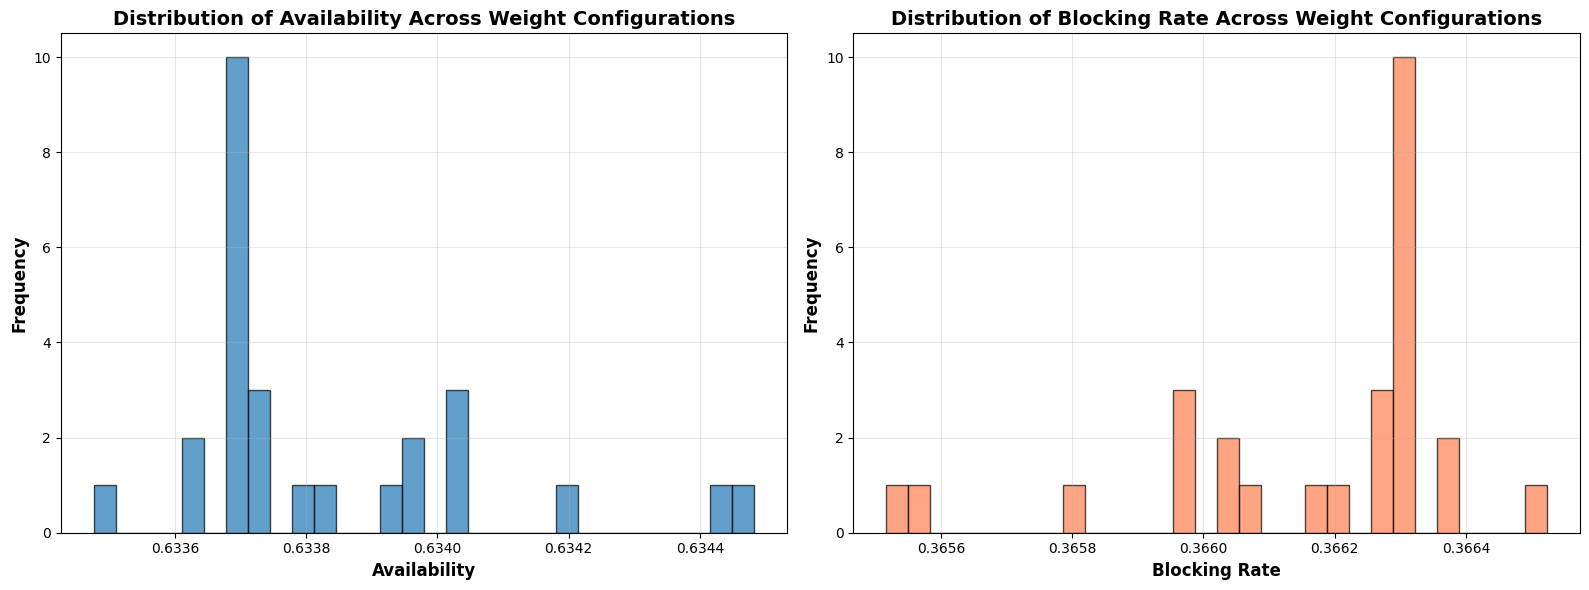


✓ Visualization saved to: output/best_weight_experiment/results_distribution.png


In [11]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Availability distribution
successful_results = summary_df[summary_df['success'] == True]
axes[0].hist(successful_results['availability'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Availability', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Availability Across Weight Configurations', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Blocking rate distribution
axes[1].hist(successful_results['blocking_rate'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Blocking Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Blocking Rate Across Weight Configurations', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_OUTPUT_DIR / 'results_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {BASE_OUTPUT_DIR / 'results_distribution.png'}")


## Results Analysis

The experiment results are organized as follows:

### Directory Structure
```
output/best_weight_experiment/
├── 0.1_0.1_0.1/
│   ├── scenario_0.1_0.1_0.1.pkl
│   └── dataframe_0.1_0.1_0.1.csv
├── 0.1_0.1_0.2/
│   ├── scenario_0.1_0.1_0.2.pkl
│   └── dataframe_0.1_0.1_0.2.csv
├── ...
├── experiment_summary.csv
└── results_distribution.png
```

### Files
- **`scenario_{α}_{β}_{γ}.pkl`**: Scenario object with specific weight configuration
- **`dataframe_{α}_{β}_{γ}.csv`**: Complete simulation results (all requests)
- **`experiment_summary.csv`**: Summary of all experiments with key metrics
- **`results_distribution.png`**: Distribution visualization

### Finding the Best Configuration
Use `experiment_summary.csv` to identify optimal weight configurations based on:
- **Highest Availability**: Best overall network performance
- **Lowest Blocking Rate**: Fewest rejected requests
- **Trade-offs**: Balance between different objectives


In [12]:
# Example: Load and analyze a specific configuration
# Uncomment and modify to analyze specific results

# # Load the best configuration
# best_config = summary_df.nlargest(1, 'availability').iloc[0]
# alpha_best = best_config['alpha']
# beta_best = best_config['beta']
# gamma_best = best_config['gamma']
# 
# print(f"Best configuration: α={alpha_best:.1f}, β={beta_best:.1f}, γ={gamma_best:.1f}")
# print(f"Availability: {best_config['availability']:.4f}")
# print(f"Blocking Rate: {best_config['blocking_rate']:.4f}")
# 
# # Load the detailed dataframe
# best_df_path = Path(best_config['output_dir']) / f"dataframe_{alpha_best:.1f}_{beta_best:.1f}_{gamma_best:.1f}.csv"
# best_df = pd.read_csv(best_df_path, low_memory=False)
# 
# # Analyze further...
# print(f"\nDetailed statistics:")
# print(f"Total requests: {len(best_df)}")
# print(f"Blocked requests: {best_df['bloqueada'].sum()}")
# print(f"Migration requests: {best_df['requisicao_de_migracao'].sum()}")

print("✓ Example code ready (uncomment to use)")


✓ Example code ready (uncomment to use)


In [13]:
# Test: Verify that different weights produce different disaster-aware paths
print("=" * 80)
print("TEST: Verifying that different weight configurations affect disaster paths")
print("=" * 80)

# Load baseline scenario (0, 0, 0) - no weighting
baseline_path = BASE_OUTPUT_DIR / "0.0_0.0_0.0" / "scenario_0.0_0.0_0.0.pkl"
with open(baseline_path, "rb") as f:
    scenario_baseline = pickle.load(f)

# Load a scenario with different weights (0.5, 0.5, 0.5) - maximum weighting
weighted_path = BASE_OUTPUT_DIR / "0.5_0.5_0.5" / "scenario_0.5_0.5_0.5.pkl"
with open(weighted_path, "rb") as f:
    scenario_weighted = pickle.load(f)

print(f"\n✓ Loaded scenarios:")
print(f"  - Baseline: α=0.0, β=0.0, γ=0.0 (no weighting)")
print(f"  - Weighted: α=0.5, β=0.5, γ=0.5 (maximum weighting)")

# Compare weighted disaster-aware paths for each ISP
differences_found = False
total_paths_compared = 0
different_paths_count = 0

for isp_baseline, isp_weighted in zip(scenario_baseline.lista_de_isps, scenario_weighted.lista_de_isps):
    isp_id = isp_baseline.isp_id
    
    # Check if this ISP has a datacenter (migration paths)
    if not hasattr(isp_baseline, 'datacenter') or isp_baseline.datacenter is None:
        continue
    
    # Get weighted disaster-aware paths
    baseline_paths = isp_baseline.weighted_caminhos_internos_isp_durante_desastre
    weighted_paths = isp_weighted.weighted_caminhos_internos_isp_durante_desastre
    
    # Compare paths for each src-dst pair
    for src in baseline_paths:
        for dst in baseline_paths[src]:
            total_paths_compared += 1
            
            # Get the paths
            baseline_path_list = baseline_paths[src][dst]
            weighted_path_list = weighted_paths[src][dst]
            
            # Compare first path (primary path)
            if baseline_path_list and weighted_path_list:
                baseline_first = baseline_path_list[0]['caminho']
                weighted_first = weighted_path_list[0]['caminho']
                
                # Check if paths are different
                if baseline_first != weighted_first:
                    differences_found = True
                    different_paths_count += 1
                    
                    if different_paths_count <= 3:  # Show first 3 examples
                        print(f"\n✓ Path difference found in ISP {isp_id} ({src} → {dst}):")
                        print(f"  Baseline path: {baseline_first}")
                        print(f"  Weighted path: {weighted_first}")

print(f"\n{'='*80}")
print("TEST RESULTS:")
print(f"{'='*80}")
print(f"Total path pairs compared: {total_paths_compared}")
print(f"Different paths found: {different_paths_count}")
print(f"Percentage of paths affected: {(different_paths_count/total_paths_compared*100):.2f}%")

# Assert that there ARE differences
assert differences_found, "❌ FAILED: No differences found in disaster-aware paths between different weight configurations!"
print(f"\n✅ TEST PASSED: Different weight configurations produce different disaster-aware routing paths")
print(f"   This confirms that the weight parameters (α, β, γ) are effectively influencing path selection.")
print("="*80)


TEST: Verifying that different weight configurations affect disaster paths

✓ Loaded scenarios:
  - Baseline: α=0.0, β=0.0, γ=0.0 (no weighting)
  - Weighted: α=0.5, β=0.5, γ=0.5 (maximum weighting)

✓ Path difference found in ISP 0 (22 → 11):
  Baseline path: [22, 16, 12, 11]
  Weighted path: [22, 16, 15, 11]

✓ Path difference found in ISP 0 (22 → 7):
  Baseline path: [22, 16, 12, 11, 6, 7]
  Weighted path: [22, 16, 15, 11, 6, 7]

✓ Path difference found in ISP 0 (22 → 6):
  Baseline path: [22, 16, 12, 11, 6]
  Weighted path: [22, 16, 15, 11, 6]

TEST RESULTS:
Total path pairs compared: 1082
Different paths found: 61
Percentage of paths affected: 5.64%

✅ TEST PASSED: Different weight configurations produce different disaster-aware routing paths
   This confirms that the weight parameters (α, β, γ) are effectively influencing path selection.
